In [1]:
%matplotlib inline
import matplotlib.pyplot as plt           # Allows to do plots
import fenics as fe                       # Allors to use the FEniCS functions
import os                                 # Allows to use path
import pandas as pd                       # Allows to use data in tables
from IPython.display import display, clear_output

In [2]:
# ----------------------------------------------------------------------------
# Parameters to set
# ----------------------------------------------------------------------------

# Folder for the results
Output_Path = 'ResultsCompressible'

# Test performed
Tests = ['Traction', 'Compression', 'Simple Shear']
Test  = Tests[2]

# Constitutive models
Models = ['Compressible Neo-Hookean', 'Compressible Ogden']
Model  = Models[1]

# Poisson's ratio
Nu     = 0.49

# Discretization (number of elements by sides)
Nelements = 1

In [3]:
# ----------------------------------------------------------------------------
# Mesh
# ----------------------------------------------------------------------------

# Geometry (mm)
Length = 5
Thickness = 5
Height = 5

# Mesh
Mesh = fe.BoxMesh(fe.Point(-Length/2, -Thickness/2, -Height/2), 
                  fe.Point( Length/2, Thickness/2, Height/2), 
                  Nelements, Nelements, Nelements)

In [4]:
# ----------------------------------------------------------------------------
# Function spaces
# ----------------------------------------------------------------------------

# Discretization
Type = 'Lagrange'
PolDegree = 1

# Functions spaces
V_ele = fe.VectorElement(Type, Mesh.ufl_cell(), PolDegree)
V = fe.VectorFunctionSpace(Mesh, Type, PolDegree)

# Finite element functions
du = fe.TrialFunction(V)
v = fe.TestFunction(V)
u = fe.Function(V)

In [5]:
# ----------------------------------------------------------------------------
# Material Constants
# ----------------------------------------------------------------------------

# Neo-Hookean
Mu_NH  = 1.15                         # (kPa)
Lambda = 2*Mu_NH*Nu/(1-2*Nu)          # (kPa)

# Ogden
Mu_Og = 0.66                          # (kPa)
alpha = -24.3                         # (-)
D     = 3*(1-2*Nu)/(Mu_Og*(1+Nu))     # (1/kPa)

In [6]:
# ----------------------------------------------------------------------------
# Kinematics
# ----------------------------------------------------------------------------

d = u.geometric_dimension()
I = fe.Identity(d)                    # Identity tensor
F = I + fe.grad(u)                    # Deformation gradient
F = fe.variable(F)                    # To differentiate Psi(F)
C = F.T*F                             # Right Cauchy-Green deformation tensor

In [7]:
# ----------------------------------------------------------------------------
# Invariants
# ----------------------------------------------------------------------------

J = fe.det(F)                         # Jacobian of F
Ic = fe.tr(C)                         # Trace of C

# Invariant of Right Cauchy-Green deformation tensor
def I1(C):
    return fe.tr(C)

def I2(C):
    c1 = C[0,0]*C[1,1] + C[0,0]*C[2,2] + C[1,1]*C[2,2]
    c2 = C[0,1]*C[0,1] + C[0,2]*C[0,2] + C[1,2]*C[1,2]
    return c1 - c2

def I3(C):
    return fe.det(C)

# Define function necessary for eigenvalues computation
def v_inv(C):
    return (I1(C)/3.)**2 - I2(C)/3.

def s_inv(C):
    return (I1(C)/3.)**3 - I1(C)*I2(C)/6. + I3(C)/2.

def phi_inv(C):
    arg = s_inv(C)/v_inv(C)*fe.sqrt(1./v_inv(C))
    # numerical issues if arg~0
    # https://fenicsproject.org/qa/12299
    # /nan-values-when-computing-arccos-1-0-bug/
    arg_cond = fe.conditional( fe.ge(arg, 1-fe.DOLFIN_EPS),
    1-fe.DOLFIN_EPS,fe.conditional( fe.le(arg, -1+fe.DOLFIN_EPS),
    -1+fe.DOLFIN_EPS, arg ))
    return fe.acos(arg_cond)/3.

# Eigenvalues of the strech tensor C
lambda_1 = Ic/3. + 2*fe.sqrt(v_inv(C))*fe.cos(phi_inv(C))
lambda_2 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. + phi_inv(C))
lambda_3 = Ic/3. - 2*fe.sqrt(v_inv(C))*fe.cos(fe.pi/3. - phi_inv(C))

In [8]:
# ----------------------------------------------------------------------------
# Constitutive model
# ----------------------------------------------------------------------------

# Compressible Neo-Hookean constitutive model
CompNeoHook = (Mu_NH/2)*(Ic - 3) - Mu_NH*fe.ln(J) + (Lambda/2)*(fe.ln(J))**2

# Compressible Modified one-term Ogden
CompOgden   = 2 * Mu_Og * (J**(-1/3)*lambda_1**(alpha/2.)
                        +  J**(-1/3)*lambda_2**(alpha/2.) 
                        +  J**(-1/3)*lambda_3**(alpha/2.) - 3) / alpha**2 + 1/D * (J-1)**2

ConstitutiveModels = [CompNeoHook, CompOgden]

In [9]:
# ----------------------------------------------------------------------------
# Total potential energy
# ----------------------------------------------------------------------------

Psi = ConstitutiveModels[0]
Pi = Psi * fe.dx

In [10]:
# ----------------------------------------------------------------------------
# Subdomains definition
# ----------------------------------------------------------------------------

# Define geometric spaces
class LowerSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], -Height/2, tol)
    
class UpperSide(fe.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and fe.near(x[2], Height/2, tol)
    
# Define integration over subdpmains
Domains_Facets = fe.MeshFunction('size_t', Mesh, Mesh.geometric_dimension()-1)
ds = fe.Measure('ds', domain=Mesh, subdomain_data=Domains_Facets)

# Mark all domain facets with 0
Domains_Facets.set_all(0)

# Mark bottom facets with 1
bottom = LowerSide()
bottom.mark(Domains_Facets, 1)

# Mark upper facets with 2
upper = UpperSide()
upper.mark(Domains_Facets, 2)

In [11]:
# ----------------------------------------------------------------------------
# Boundary conditions
# ----------------------------------------------------------------------------

# Fixed side
u_0 = fe.Constant((0, 0, 0)) # No displacement

# Normal to moving side
n = fe.Constant((0, 0, 1))

# Diverse definitions
IniS = [1, 1, 0]                      # Initial state (-)
FinS = [1.1, 0.9, 0.2]                # Final state/stretch (-)
Ymin = [-0.1, 0.1, -0.01]
Ymax = [1.5, -1.5, 0.15]
NumberSteps = 10                      # Number of steps (-)

# Boundary conditions definition
if Test == Tests[0]:
    IniS = IniS[0]
    FinS = FinS[0]
    Ymin = Ymin[0]
    Ymax = Ymax[0]
    u_1 = fe.Expression(('0', '0', '(s-1)*h'),
    degree=1, s = IniS, h = Height )                   # Displacement imposed
    Dir = fe.Constant((0,0,1))                         # Deformation direction
    DeltaStretch = round((FinS-IniS)/NumberSteps,3)    # Stretch step (-)
    
elif Test == Tests[1]:
    IniS = IniS[1]
    FinS = FinS[1]
    Ymin = Ymin[1]
    Ymax = Ymax[1]
    u_1 = fe.Expression(('0', '0', '(s-1)*h'),
    degree=1, s = IniS, h = Height )                   # Displacement imposed
    Dir = fe.Constant((0,0,1))                         # Deformation direction
    DeltaStretch = round((FinS-IniS)/NumberSteps,3)    # Stretch step (-)

elif Test == Tests[2]:
    IniS = IniS[2]
    FinS = FinS[2]
    Ymin = Ymin[2]
    Ymax = Ymax[2]
    u_1 = fe.Expression(('s*h', '0', '0'),
    degree=1, s = IniS, h = Height )                   # Displacement imposed
    Dir = fe.Constant((1,0,0))                         # Deformation direction
    DeltaStretch = round((FinS-IniS)/NumberSteps,3)    # Stretch step (-)

    
# Apply boundary conditionsParameters to set
bcl = fe.DirichletBC(V, u_0, Domains_Facets, 1)
bcu = fe.DirichletBC(V, u_1, Domains_Facets, 2)

# Set of boundary conditions
bcs = [bcl, bcu]

In [12]:
# ----------------------------------------------------------------------------
# Problem to solve
# ----------------------------------------------------------------------------

# First directional derivative of the potential energy
Fpi = fe.derivative(Pi,u,v)

# Jacobian of Fpi
Jac = fe.derivative(Fpi,u,du)

# Define option for the compiler (optional)
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True }

# Define the problem
problem = fe.NonlinearVariationalProblem(Fpi, u, bcs, Jac,
form_compiler_parameters=ffc_options)

# Define the solver
solver = fe.NonlinearVariationalSolver(problem)

# Set solver parameters (optional)
prm = solver.parameters
prm['nonlinear_solver'] = 'newton'
prm['newton_solver']['linear_solver'] = 'cg'             # Conjugate gradient
prm['newton_solver']['preconditioner'] = 'icc'           # Incomplete Choleski

In [13]:
# ----------------------------------------------------------------------------
# Results File
# ----------------------------------------------------------------------------

os.makedirs(Output_Path, exist_ok=True)
FileName = 'Nu' + str(Nu) + '_' + str(Nelements) + 'Elements_' + Test

results = xdmffile = fe.XDMFFile(os.path.join(Output_Path, FileName + '.xdmf'))
results.parameters['flush_output'] = True
results.parameters['functions_share_mesh'] = True

# Data frame to store values
cols = ['Stretches','P']
df = pd.DataFrame(columns=cols, index=range(int(NumberSteps)+1))

# Set the stretch state to initial state
StretchState = IniS

In [14]:
# ----------------------------------------------------------------------------
# Estimation of the results (only necessary for Ogden)
# ----------------------------------------------------------------------------

if Model == Models[1]:

    # Update boundary condition for non zero displacement
    u_1.s = IniS + 0.001

    # Compute solution and save displacement
    solver.solve()
    
    # Change constitutive model
    Psi = ConstitutiveModels[1]
    Pi = Psi * fe.dx
    
    # First directional derivative of the potential energy
    Fpi = fe.derivative(Pi,u,v)

    # Jacobian of Fpi
    Jac = fe.derivative(Fpi,u,du)
    
    # Define the problem
    problem = fe.NonlinearVariationalProblem(Fpi, u, bcs, Jac,
    form_compiler_parameters=ffc_options)

    # Define the solver
    solver = fe.NonlinearVariationalSolver(problem)
    
    # Set the stretch state to initial state
    StretchState = IniS

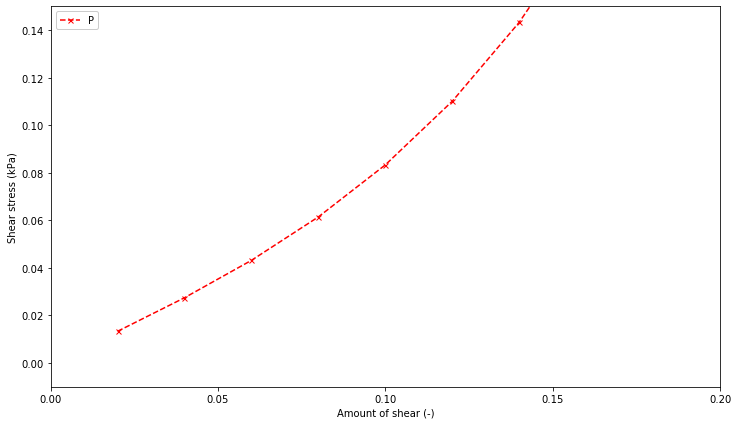

In [15]:
# ----------------------------------------------------------------------------
# Solve
# ----------------------------------------------------------------------------

plt.rc('figure', figsize=[12,7])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for Step in range(NumberSteps+1):
    
    # Update current state
    u_1.s = StretchState
    
    # Compute solution and save displacement
    solver.solve()
    
    # First Piola Kirchoff (nominal) stress
    P = fe.diff(Psi, F)
    
    # Nominal stress vectors normal to upper surface
    p = fe.dot(P,n)
    
    # Reaction force on the upper surface
    f = fe.assemble(fe.inner(p,Dir)*ds(2))
    
    # Mean nominal stress on the upper surface
    Pm = f/fe.assemble(1*ds(2))
    
    # Project the displacement onto the vector function space
    u_project = fe.project(u, V, solver_type='cg')
    u_project.rename('displacement (mm)', '')
    results.write(u_project,Step)
    
    # Save values to table
    df.loc[Step].Stretches = StretchState
    df.loc[Step].P = Pm
    
    # Plot
    ax.cla()
    ax.plot(df.Stretches, df.P,  color = 'r', 
            linestyle = '--', label = 'P', marker = 'x', markersize = 5)
    if Test == Tests[2]:
        ax.set_xlabel('Amount of shear (-)')
        ax.set_ylabel('Shear stress (kPa)')
        ax.xaxis.set_major_locator(plt.MultipleLocator(0.05))
    else:
        ax.set_xlabel('Stretch ratio (-)')
        ax.set_ylabel('Stresses (kPa)')
        ax.xaxis.set_major_locator(plt.MultipleLocator(0.02))
    ax.set_xlim(IniS,FinS)
    ax.set_ylim(Ymin,Ymax)
    ax.legend(loc='upper left', frameon=True, framealpha=1)
    display(fig)
    clear_output(wait=True)
            
    # Update the stretch state
    StretchState += DeltaStretch
    
# Save table and figure
df.to_pickle(os.path.join(Output_Path, FileName + 'Stress'))
plt.savefig(os.path.join(Output_Path, FileName + '.pdf'))

In [16]:
df

,Stretches,P
0,0,NaN
1,0.02,0.0133294
2,0.04,0.0274441
3,0.06,0.0431749
4,0.08,0.0614454
5,0.1,0.0833256
6,0.12,0.110093
7,0.14,0.143303
8,0.16,0.184882
9,0.18,0.23723
